
## 1. 项目介绍
> 来自Kaggle的数据集包含了泰坦尼克号上 2224 名乘客和船员中 891 名的人口学数据和乘客基本信息。分析有哪些因素会让船上的人生还率更高？

> 1. 女性的生还率会比较高
2. 儿童的生还率会比较高
3. 乘员级别高的生还率会比较高

## 2. 数据清理

In [70]:
import pandas as pd
import numpy as np


# 读取csv文件
filename = "titanic_data.csv"
df = pd.read_csv(filename)

# 清理数据
def format_df(df):
    # 处理缺失的年龄值
    df["Age"] = df["Age"].fillna(0)
    # 转换年龄为浮点型
    df["Age"] = df["Age"].apply(float)
    return df


df = format_df(df)


def append_age_sex_column(c):
    if c["Age"] > 18:
        if c["Sex"] == "male":
            return "man"
        elif c["Sex"] == "female":
            return "woman"
        else:
            return np.NaN
    elif 0 < c["Age"] <= 18:
        return "child"
    else:
        return np.NaN
    

# 增加age_sex列（小于等于18岁的青少年为"Child"，大于18岁男子为"Man"，
# 大于18岁女子为"Woman")
df["Age_Sex"] = df.apply(append_age_sex_column, axis=1)

def calc_survival_ratio(df, key, *value):
    if key == "age":       
        series = df[(df.Age > value[0])
                   & (df.Age <= value[1])]["Survived"]
    elif key == "sex":
        series = df[df.Sex == value[0]]["Survived"]
    elif key == "level":
        series = df[df.Pclass == value[0]]["Survived"]
    elif key == "age_sex":
        series = df[df.Age_Sex == value[0]]["Survived"]
    elif key == "age_sex_level":
        series = df[(df.Age_Sex == value[0])
                    & (df.Pclass == value[1])]["Survived"]
    
    saved_ratio = series.sum() / (series.shape[0] * 1.0)
    return saved_ratio

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Sex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,man
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,woman
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,woman
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,woman
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,man


## 3. 分析数据
### 3.1. 按age组进行分析
#### 分组方式
> 小于等于18岁的一组，大于18岁为一组

#### 结论
> 
"从柱状图可以看出，儿童的生还率>成人的生还率

Populating the interactive namespace from numpy and matplotlib


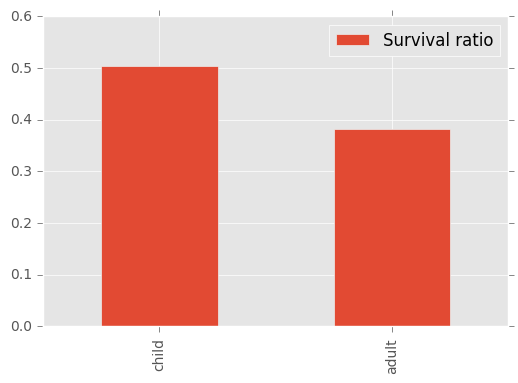

In [71]:
age_group_saved_df = pd.DataFrame(
    data={"Survival ratio": [calc_survival_ratio(df, "age", 0, 18), 
                          calc_survival_ratio(df, "age", 18, 100)]},
    index=["child", "adult"]
)


%pylab inline
import matplotlib.pyplot as plt

age_group_saved_df.index = [
    "child", "adult"
]
age_group_saved_df.plot(kind="bar")

### 3.2. 按sex组进行分析
#### 分组方式
> 男性为一组，女性为一组

#### 结论
> 从柱状图可以看出，女性的生还率>男性的生还率

Populating the interactive namespace from numpy and matplotlib


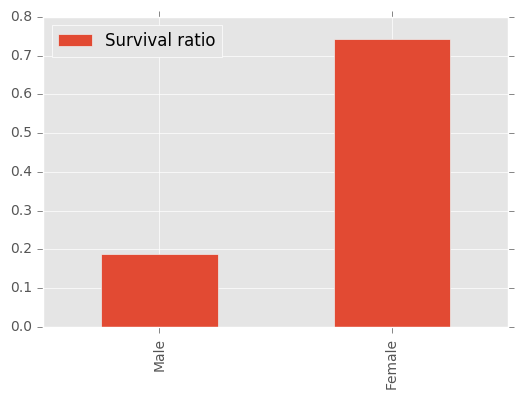

In [72]:

  
age_group_saved_df = pd.DataFrame(
    data={"Survival ratio": [calc_survival_ratio(df, "sex", "male"), 
                          calc_survival_ratio(df, "sex", "female")]},
    index=["Male", "Female"]
)


%pylab inline
import matplotlib.pyplot as plt

age_group_saved_df.index = [
    "Male", "Female"
]
age_group_saved_df.plot(kind="bar")

### 3.3. 按level组进行分析
#### 分组方式
> class1为一组，class2为一组，class3为一组

#### 结论
> 从柱状图可以看出，class1 > class2 > class3

Populating the interactive namespace from numpy and matplotlib


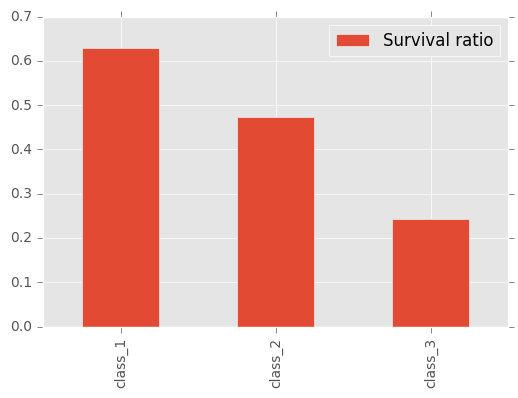

In [73]:
class_group_saved_df = pd.DataFrame(
    data={"Survival ratio": [calc_survival_ratio(df, "level", 1), 
                             calc_survival_ratio(df, "level", 2),
                             calc_survival_ratio(df, "level", 3)]},
    index=["class 1", "class 2", "class 3"]
)

%pylab inline
import matplotlib.pyplot as plt

class_group_saved_df.index = [
    "class_1", "class_2", "class_3"
]
class_group_saved_df.plot(kind="bar")

### 3.4. 按age_sex组进行分析
#### 分组方式
> 按Child，Woman，Man分成三组

#### 结论
> 从柱状图可以看出，生还率woman>child>man

Populating the interactive namespace from numpy and matplotlib


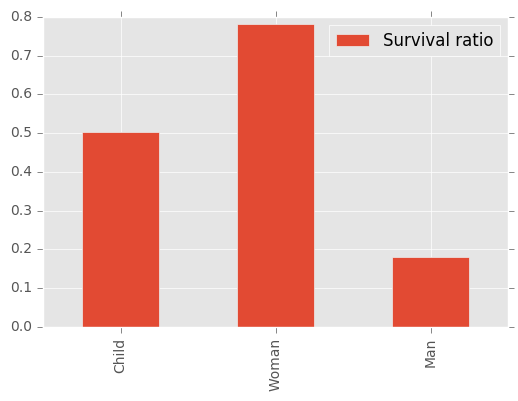

In [74]:
class_group_saved_df = pd.DataFrame(
    data={"Survival ratio": [calc_survival_ratio(df, "age_sex", "child"), 
                             calc_survival_ratio(df, "age_sex", "woman"),
                             calc_survival_ratio(df, "age_sex", "man")]},
    index=["Child", "Woman", "Man"]
)

%pylab inline
import matplotlib.pyplot as plt

class_group_saved_df.index = [
    "Child", "Woman", "Man"
]
class_group_saved_df.plot(kind="bar")

### 3.5. 按age+sex+level组进行分析
#### 分组方式
> Child按class分三组，Woman按class分三组，Man按class分三组，

#### 结论
> 
从柱状图可以看出，除了man中class3大约class2，其他乘员级别内都按class顺序排列；woman略高于child，man最低

Populating the interactive namespace from numpy and matplotlib


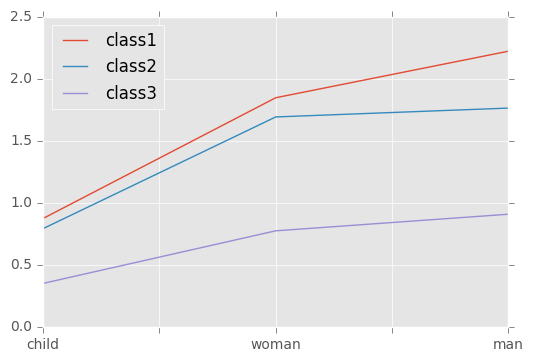

In [75]:
# age_class_group_saved_df = pd.DataFrame(

#     np.array([
#             [calc_survival_ratio(df, "age_sex_level", "child", 1),
#              calc_survival_ratio(df, "age_sex_level", "child", 2),
#              calc_survival_ratio(df, "age_sex_level", "child", 3)],
#             [calc_survival_ratio(df, "age_sex_level", "woman", 1),
#              calc_survival_ratio(df, "age_sex_level", "woman", 2),
#              calc_survival_ratio(df, "age_sex_level", "woman", 3)],
#             [calc_survival_ratio(df, "age_sex_level", "man", 1),
#              calc_survival_ratio(df, "age_sex_level", "man", 2),
#              calc_survival_ratio(df, "age_sex_level", "man", 3)]
#             ]),
    
#     columns=["class1", "class2", "class3"]
# )

age_class_group_saved_df = pd.DataFrame(

    np.array([
            [calc_survival_ratio(df, "age_sex_level", "child", 1),
             calc_survival_ratio(df, "age_sex_level", "child", 2),
             calc_survival_ratio(df, "age_sex_level", "child", 3)],
            [calc_survival_ratio(df, "age_sex_level", "woman", 1),
             calc_survival_ratio(df, "age_sex_level", "woman", 2),
             calc_survival_ratio(df, "age_sex_level", "woman", 3)],
            [calc_survival_ratio(df, "age_sex_level", "man", 1),
             calc_survival_ratio(df, "age_sex_level", "man", 2),
             calc_survival_ratio(df, "age_sex_level", "man", 3)]
            ]),
    index=["child", "woman", "man"],
    columns=["class1", "class2", "class3"]
)

%pylab inline
import matplotlib.pyplot as plt

# age_class_group_saved_df.index = ["child", "woman", "man"]
# age_class_group_saved_df.plot(kind="bar")

matplotlib.style.use('ggplot')
df = age_class_group_saved_df.cumsum()
plt.figure(); 
df.plot();
